## Imports

In [1]:
import os
import pickle
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.patches as patches

from PIL import Image, ImageDraw
from ultralytics import YOLO
from ultralyticsplus import render_result
import cv2 as cv

import sys

sys.path.append("RAFT/core")
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
from object_detection_utils import (
    COLORS,
    preprocess,
    box_cxcywh_to_xyxy,
    rescale_bboxes,
    batch_detect,
    detect,
    plot_results,
    plot_batch_detections,
    plot_results_avenue,
    load_images_from_folder,
    list_image_files,
    save_cropped_images,
    get_directory_names,
    imshow,
)

from optical_flow_raft_utils import (
    Args,
    plot_results,
    process_image,
    find_bounding_boxes,
    inference,
    load_model,
    display_flow_low_flow_up,
    filter_bounding_boxes_by_area,
    merge_bounding_boxes,
)

## RAFT Examples Visualization

#### Benchmark

```
raft-sintel.pth -> 32.6ms to compute flow between 2 frames -> 27fps
raft-small.pth -> 25.4ms to compute flow between 2 frames -> 40fps
```

In [3]:
# # Normal Model
# model = load_model("RAFT/models/raft-sintel.pth", args=Args())

# # Small Model
# # model = load_model("RAFT/models/raft-small.pth", args=Args(small=True, mixed_precision=True, alternate_corr=True))

# model = model.to(device) # Redundant, but to be sure
# model.eval()

In [4]:
# %%timeit -n 100
# # benchmark
# with torch.no_grad():
#     # Run the model on the batch
#     flow_low, flow_up = inference(model, np.array(frame1), np.array(frame2), device='cuda', test_mode=True)

### Example: Constructing Bounding boxes from Flow

In [5]:
%%capture
model = load_model("RAFT/models/raft-sintel.pth", args=Args())
model = model.to(device)
model.eval()

In [6]:
# Read 2 frames
transform = T.Compose(
    [
        # T.Resize((500, 500)),  # Assuming 800 is the input size for the model
        T.ToTensor(),
        # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

#### Avenue Example

In [7]:
# image_tensor, image = preprocess("./datasets/Avenue Dataset/test__/02/0288.jpg", transform=transform)

image_tensor, frame1 = preprocess(
    "./datasets/Avenue Dataset/test__/02/0290.jpg", transform=transform
)
image_tensor, frame2 = preprocess(
    "./datasets/Avenue Dataset/test__/02/0292.jpg", transform=transform
)

In [8]:
flow_low, flow_up = inference(
    model, np.array(frame1), np.array(frame2), device="cuda", test_mode=True
)

/mnt/c/Users/Sergiu/Desktop/AnomalyDetection/venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


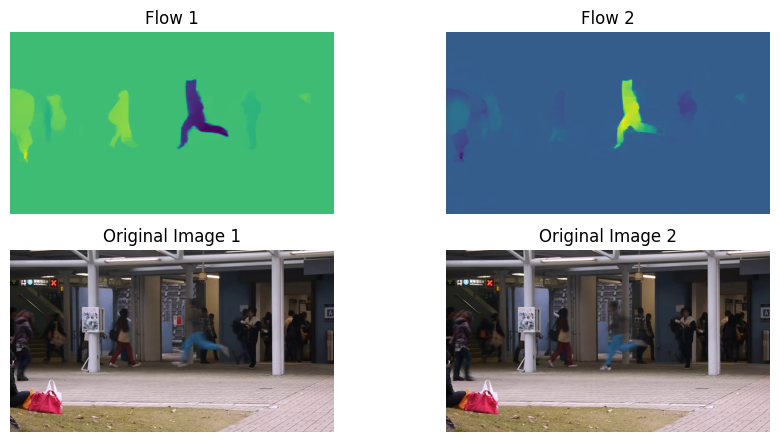

In [9]:
%matplotlib inline
(np_orig_image1, np_seg_map1, np_orig_image2, np_seg_map2) = display_flow_low_flow_up(
    frame1, frame2, flow_low, flow_up
)

[[329, 93, 432, 232], [456, 116, 496, 233], [67, 136, 82, 216]]


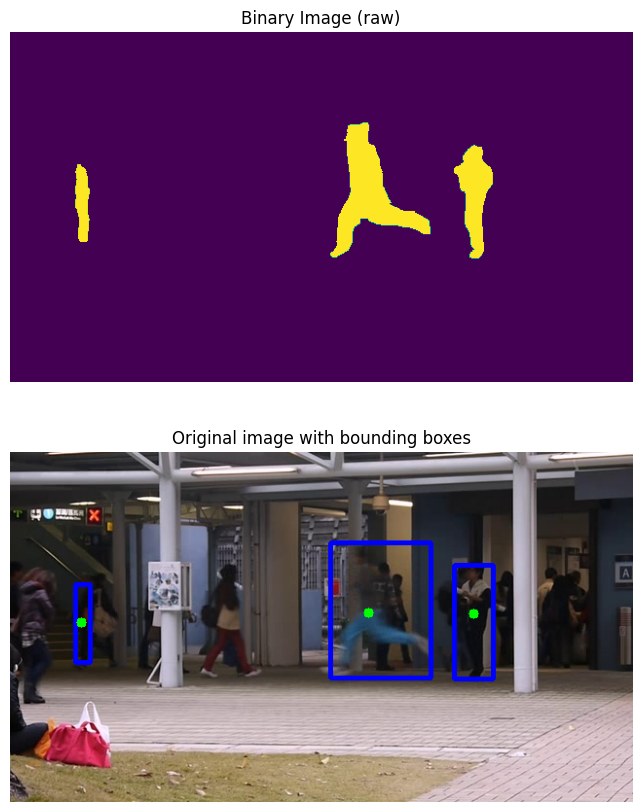

In [10]:
# Example usage
threshold_avenue = 200
bounding_boxes = find_bounding_boxes(
    np_orig_image1,
    np_seg_map1,
    threshold=threshold_avenue,
    min_area_threshold=200,
    debug=True,
)
print(bounding_boxes)

### Shanghaitech Example

In [11]:
# image_tensor, frame1 = preprocess("./datasets/shanghaitech/testing/frames/02_0128/347.jpg", transform=transform)
# image_tensor, frame2 = preprocess("./datasets/shanghaitech/testing/frames/02_0128/349.jpg", transform=transform)

image_tensor, frame1 = preprocess(
    "./datasets/shanghaitech/testing/frames/01_0134/278.jpg", transform=transform
)
image_tensor, frame2 = preprocess(
    "./datasets/shanghaitech/testing/frames/01_0134/300.jpg", transform=transform
)

In [12]:
flow_low, flow_up = inference(
    model, np.array(frame1), np.array(frame2), device="cuda", iters=50, test_mode=True
)

In [13]:
# flow_iters = inference(model, np.array(frame1), np.array(frame2), device='cuda', iters=50, test_mode=False)

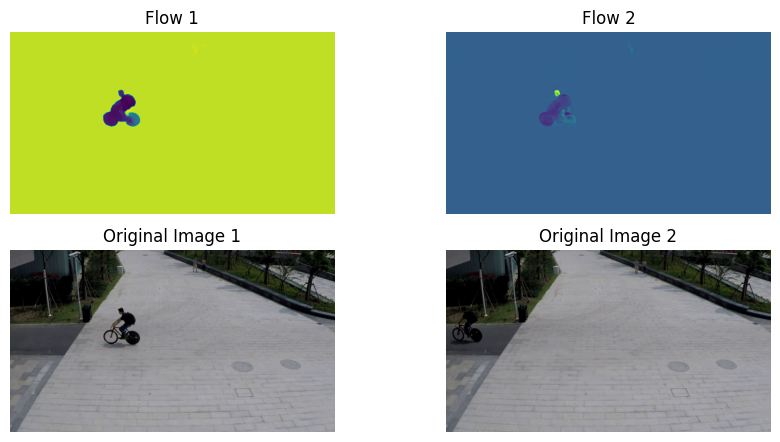

In [14]:
%matplotlib inline
(np_orig_image1, np_seg_map1, np_orig_image2, np_seg_map2) = display_flow_low_flow_up(
    frame1, frame2, flow_low, flow_up
)

[[475, 26, 495, 58], [496, 31, 500, 32], [503, 31, 517, 42], [244, 148, 343, 256]]


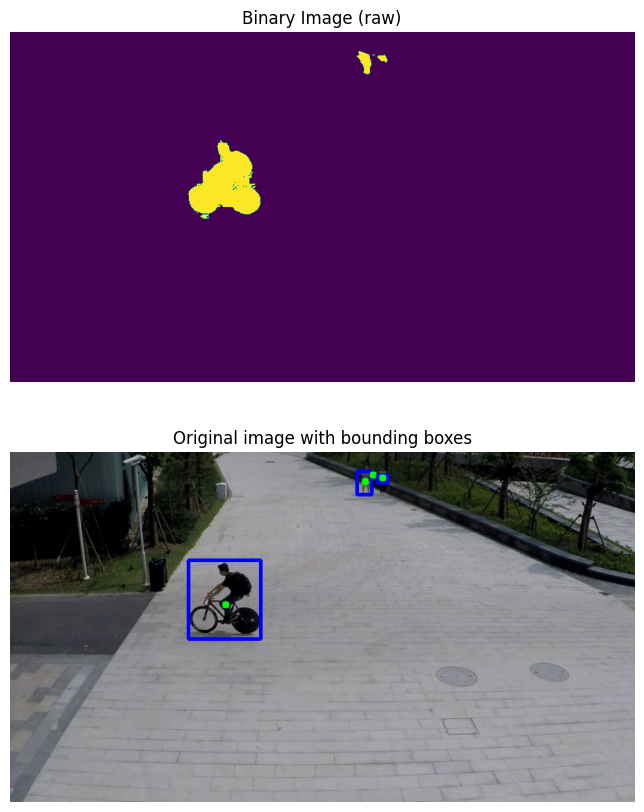

In [15]:
# Example usage
threshold_shanghai = 0
bounding_boxes = find_bounding_boxes(
    np_orig_image1,
    np_seg_map1,
    threshold=threshold_shanghai,
    min_area_threshold=0,
    debug=True,
)
print(bounding_boxes)

### UBNormal example

In [16]:
# image_tensor, frame1 = preprocess("./datasets/shanghaitech/testing/frames/02_0128/347.jpg", transform=transform)
# image_tensor, frame2 = preprocess("./datasets/shanghaitech/testing/frames/02_0128/349.jpg", transform=transform)

image_tensor, frame1 = preprocess(
    "./datasets/UBNormal/test/test_abnormal_frames/abnormal_scene_3_scenario_1/abnormal_scene_3_scenario_1_0117.jpg",
    transform=transform,
)
image_tensor, frame2 = preprocess(
    "./datasets/UBNormal/test/test_abnormal_frames/abnormal_scene_3_scenario_1/abnormal_scene_3_scenario_1_0127.jpg",
    transform=transform,
)

In [17]:
flow_low, flow_up = inference(
    model, np.array(frame1), np.array(frame2), device="cuda", iters=20, test_mode=True
)

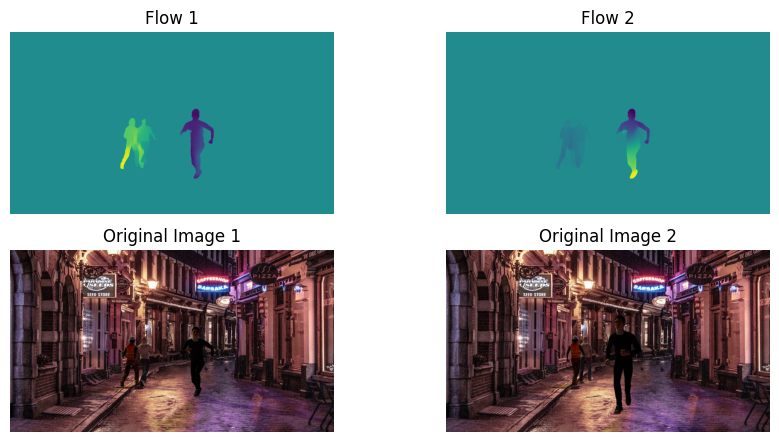

In [18]:
%matplotlib inline
(np_orig_image1, np_seg_map1, np_orig_image2, np_seg_map2) = display_flow_low_flow_up(
    frame1, frame2, flow_low, flow_up
)

## Interweave predictions (bounding boxes) from Optical Flow and from Object Detection

In [19]:
# Read obj_det_avenue_test
with open(
    f"optical_flow_raft_ubnormal_thresh_0_minarea_0_iterations_20_lookahead_3", "rb"
) as file:
    obj_dect_opt_flow = pickle.load(file)

In [20]:
# Example usage
list1 = [[100, 100, 200, 200], [300, 300, 400, 400]]  # First list of bounding boxes
list2 = [[150, 150, 250, 250], [350, 350, 450, 450]]  # Second list of bounding boxes

merged_boxes = merge_bounding_boxes(list1, list2, iou_threshold=0.3)
print(merged_boxes)

[[100, 100, 200, 200], [300, 300, 400, 400], [150, 150, 250, 250], [350, 350, 450, 450]]


In [ ]:
obj_dect_opt_flow.keys()

#### Avenue Obj Dect Conf

In [22]:
# # Read obj_det_avenue_test
# with open('obj_dect_avenue_yolov8_conf_086', 'rb') as file:
#     obj_dect_avenue = pickle.load(file)

# print(obj_dect_avenue.keys())

dict_keys(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'])


#### Shanghaitech Obj Dect Conf

In [49]:
# # 'obj_dect_shanghaitech_detr_resnet_50_dc5_thresh_95'
# with open("obj_dect_shanghaitech_detr_resnet_50_dc5_thresh_92", "rb") as file:
#     obj_dect_avenue = pickle.load(file)

# print(obj_dect_avenue.keys())

dict_keys(['01_0014', '01_0015', '01_0016', '01_0025', '01_0026', '01_0027', '01_0028', '01_0029', '01_0030', '01_0051', '01_0052', '01_0053', '01_0054', '01_0055', '01_0056', '01_0063', '01_0064', '01_0073', '01_0076', '01_0129', '01_0130', '01_0131', '01_0132', '01_0133', '01_0134', '01_0135', '01_0136', '01_0138', '01_0139', '01_0140', '01_0141', '01_0162', '01_0163', '01_0177', '02_0128', '02_0161', '02_0164', '03_0031', '03_0032', '03_0033', '03_0035', '03_0036', '03_0039', '03_0041', '03_0059', '03_0060', '03_0061', '04_0001', '04_0003', '04_0004', '04_0010', '04_0011', '04_0012', '04_0013', '04_0046', '04_0050', '05_0017', '05_0018', '05_0019', '05_0020', '05_0021', '05_0022', '05_0023', '05_0024', '06_0144', '06_0145', '06_0147', '06_0150', '06_0153', '06_0155', '07_0005', '07_0006', '07_0007', '07_0008', '07_0009', '07_0047', '07_0048', '07_0049', '08_0044', '08_0058', '08_0077', '08_0078', '08_0079', '08_0080', '08_0156', '08_0157', '08_0158', '08_0159', '08_0178', '08_0179',

#### UBNormal

In [ ]:
# 'obj_dect_shanghaitech_detr_resnet_50_dc5_thresh_95'
with open("obj_dect_ubnormal_yolov8_conf_080", "rb") as file:
    obj_dect_avenue = pickle.load(file)

print(obj_dect_avenue.keys())

In [25]:
assert obj_dect_avenue.keys() == obj_dect_opt_flow.keys()

In [26]:
# Example usage
bounding_boxes = [[10, 10, 50, 50], [20, 20, 30, 30], [100, 100, 200, 200]]
min_area = 200  # Minimum area threshold

filtered_boxes = filter_bounding_boxes_by_area(bounding_boxes, min_area)
print(filtered_boxes)

[[10, 10, 50, 50], [100, 100, 200, 200]]


In [35]:
# Construct combined dict
obj_dect_yolov8_raft = {}

# iou_threshold = 0.3  # IoU threshold for considering boxes as distinct
# iou_threshold = 0.5
# iou_threshold = 0.6
# iou_threshold = 0.7
iou_threshold = 0.8

min_area = 2000
# Go through all videos and their frames
for vid_name, vid_frames in obj_dect_avenue.items():
    bbox_temp = {}

    for frame_idx in vid_frames:
        # Get bboxes from obj detection for a given frame
        obj_det_bboxes = vid_frames[frame_idx]

        # get bboxes from optical flow for a given frame
        opt_flow_bboxes = obj_dect_opt_flow[vid_name][frame_idx]

        # Get non-overlapping boxes from YoloV8 and optical flow
        merged_boxes = merge_bounding_boxes(
            obj_det_bboxes, opt_flow_bboxes, iou_threshold=iou_threshold
        )

        # Remove small Objects
        # merged_boxes = filter_bounding_boxes_by_area(merged_boxes, min_area)

        bbox_temp[frame_idx] = merged_boxes

    obj_dect_yolov8_raft[vid_name] = bbox_temp

In [36]:
# Save the object to a file
with open(
    f"obj_dect_080_yolov8_ubnormal_optical_flow_raft_thresh_0_minarea_2000_lookahead_3_iou_08",
    "wb",
) as file:
    pickle.dump(obj_dect_yolov8_raft, file)

## End of Notebook